In [1]:
import numpy as np
from numpy import random
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units as u
from astroquery.svo_fps import SvoFps
from synphot import SourceSpectrum, SpectralElement, Observation, units
from synphot.models import BlackBodyNorm1D, Empirical1D


In [2]:
# Get the list of OAJ/JPCam filters
JPAS_filter_list = SvoFps.get_filter_list(facility='OAJ', instrument='JPCam').to_pandas()
# Filters of interest
JPAS_filter_ids = ('OAJ/JPAS.uJava', 'OAJ/JPAS.u',     'OAJ/JPAS.J0378', 'OAJ/JPAS.J0390', 'OAJ/JPAS.J0400',
                   'OAJ/JPAS.J0410', 'OAJ/JPAS.J0420', 'OAJ/JPAS.J0430', 'OAJ/JPAS.J0440', 'OAJ/JPAS.J0450',
                   'OAJ/JPAS.J0460', 'OAJ/JPAS.J0470', 'OAJ/JPAS.J0480', 'OAJ/JPAS.gSDSS', 'OAJ/JPAS.J0490',
                   'OAJ/JPAS.J0500', 'OAJ/JPAS.J0510', 'OAJ/JPAS.J0520', 'OAJ/JPAS.J0530', 'OAJ/JPAS.J0540',
                   'OAJ/JPAS.J0550', 'OAJ/JPAS.J0560', 'OAJ/JPAS.J0570', 'OAJ/JPAS.J0580', 'OAJ/JPAS.J0590',
                   'OAJ/JPAS.J0600', 'OAJ/JPAS.J0610', 'OAJ/JPAS.J0620', 'OAJ/JPAS.rSDSS', 'OAJ/JPAS.J0630',
                   'OAJ/JPAS.J0640', 'OAJ/JPAS.J0650', 'OAJ/JPAS.J0660', 'OAJ/JPAS.J0670', 'OAJ/JPAS.J0680',
                   'OAJ/JPAS.J0690', 'OAJ/JPAS.J0700', 'OAJ/JPAS.J0710', 'OAJ/JPAS.J0720', 'OAJ/JPAS.J0730',
                   'OAJ/JPAS.J0740', 'OAJ/JPAS.J0750', 'OAJ/JPAS.J0760', 'OAJ/JPAS.iSDSS', 'OAJ/JPAS.J0770',
                   'OAJ/JPAS.J0780', 'OAJ/JPAS.J0790', 'OAJ/JPAS.J0800', 'OAJ/JPAS.J0810', 'OAJ/JPAS.J0820',
                   'OAJ/JPAS.J0830', 'OAJ/JPAS.J0840', 'OAJ/JPAS.J0850', 'OAJ/JPAS.J0860', 'OAJ/JPAS.J0870',
                   'OAJ/JPAS.J0880', 'OAJ/JPAS.J0890', 'OAJ/JPAS.J0900', 'OAJ/JPAS.J0910', 'OAJ/JPAS.J1007')
# Filters transmission data
JPAS_waveRefAA = {} # WavelengthRef dict
JPAS_bp = {} # Bandpass dict
for filter_id in JPAS_filter_ids:
    JPAS_filter_tx = SvoFps.get_transmission_data(filter_id)
    JPAS_waveRefAA[filter_id] = JPAS_filter_list[JPAS_filter_list.filterID==filter_id].WavelengthRef.values[0]
    JPAS_bp[filter_id] = SpectralElement(Empirical1D, points=JPAS_filter_tx['Wavelength'], lookup_table=JPAS_filter_tx['Transmission'])


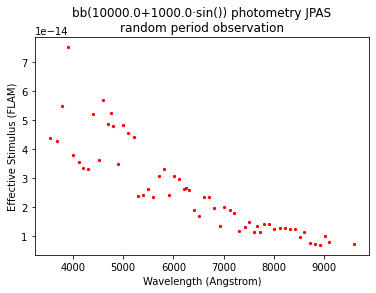

In [5]:
# Observations for each filter at a random phase of a black body sine (centered at 10000 K, amplitude 1000 K)
xvar = np.arange(0, 2*np.pi, 0.1) # Phase: 0 to 2PI, step 0.1
yvar = np.sin(xvar)*1000+10000    # Temperature sine
JPAS_obs_effstim = {}
for k in JPAS_bp:
    i = random.randint(len(xvar))
    obs = Observation(SourceSpectrum(BlackBodyNorm1D, temperature=yvar[i]), JPAS_bp[k], binset=range(3000, 11000))
    JPAS_obs_effstim[k] = obs.effstim('flam').value
plt.scatter(JPAS_waveRefAA.values(), JPAS_obs_effstim.values(), s=5, c='r')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Effective Stimulus (FLAM)')
plt.title('bb(10000.0+1000.0·sin()) photometry JPAS\nrandom period observation')
plt.show()


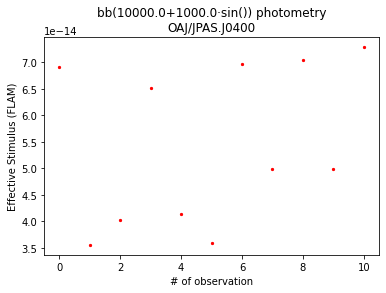

In [6]:
# Observations for one specific filter f at N random phases of the black body sine
f = 'OAJ/JPAS.J0400'
N = 11

t = np.arange(0, N, 1)
JPAS_obs_effstim = {}
for k in range(len(t)):
    i = random.randint(len(xvar))
    obs = Observation(SourceSpectrum(BlackBodyNorm1D, temperature=yvar[i]), JPAS_bp[f], binset=range(3000, 11000))
    JPAS_obs_effstim[k] = obs.effstim('flam').value
plt.scatter(t, JPAS_obs_effstim.values(), s=5, c='r')
plt.xlabel('# of observation')
plt.ylabel('Effective Stimulus (FLAM)')
plt.title('bb(10000.0+1000.0·sin()) photometry\n'+f)
plt.show()


In [7]:
# Compute ALL effective stimulus for ALL filters (takes some time!!)
JPAS_obs = defaultdict(dict)
for i in range(len(xvar)):
    for k in JPAS_bp:
        obs = Observation(SourceSpectrum(BlackBodyNorm1D, temperature=yvar[i]), JPAS_bp[k], binset=range(3000, 11000))
        JPAS_obs[xvar[i]][k] = obs.effstim('flam').value


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
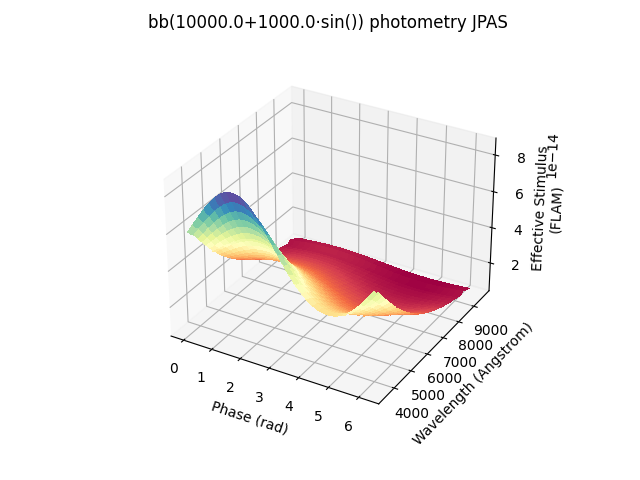

In [8]:
# Plot effective stimulus per phase and filter (3D)
%matplotlib widget
X = xvar # Phase
Y = list(JPAS_waveRefAA.values()) # Filters wavelength
X, Y = np.meshgrid(X, Y)
Z = []
for period, filter_id in JPAS_obs.items():
    Zpre = []
    for filtid, effstim in filter_id.items():
        Zpre.append(effstim)
    Z.append(Zpre)
Z = np.array(Z).T
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.Spectral, linewidth=0, antialiased=False)
ax.set_zlabel('Effective Stimulus\n(FLAM)')
plt.xlabel('Phase (rad)')
plt.ylabel('Wavelength (Angstrom)')
plt.title('bb(10000.0+1000.0·sin()) photometry JPAS\n')
plt.show()
